In [1]:
import numpy as np
from matplotlib import pyplot as plt
# import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import copy
import pickle

# Importing data

In [2]:
def data_import(data_path):
    class_labels = os.listdir(data_path) # reads directory names as class-labels
    data=[]
    labels=[]
    for class_ in class_labels:
        if class_ == '.DS_Store':
            continue
        class_path = data_path+'/'+class_
        imgs = os.listdir(class_path) # reads images names to read
        for img in imgs:
            if img == '.DS_Store':
                continue
            data.append(cv2.imread(class_path+'/'+img, cv2.IMREAD_GRAYSCALE))
            labels.append(int(class_))

    return np.array(data), np.array(labels)

In [3]:
test_path='./Group_10/test'
train_path='./Group_10/train'
val_path='./Group_10/val'
# test_data, test_labels = data_import(test_path)
# train_data, train_labels = data_import(train_path)
# val_data, val_labels = data_import(val_path)

# with open('test_data', mode='wb') as f:
#     pickle.dump(test_data, f)
# with open('train_data', mode='wb') as f:
#     pickle.dump(train_data, f)
# with open('val_data', mode='wb') as f:
#     pickle.dump(val_data, f)

# with open('test_labels', mode='wb') as f:
#     pickle.dump(test_labels, f)
# with open('train_labels', mode='wb') as f:
#     pickle.dump(train_labels, f)
# with open('val_labels', mode='wb') as f:
#     pickle.dump(val_labels, f)

with open('test_data', mode='rb') as f:
    test_data = pickle.load(f)
with open('train_data', mode='rb') as f:
    train_data = pickle.load(f)
with open('val_data', mode='rb') as f:
    val_data = pickle.load(f)

with open('test_labels', mode='rb') as f:
    test_labels = pickle.load(f)
with open('train_labels', mode='rb') as f:
    train_labels = pickle.load(f)
with open('val_labels', mode='rb') as f:
    val_labels = pickle.load(f)

print('Summary of data')
print(f'No. of train images: {len(train_data)}')
print(f'No. of test images: {len(test_data)}')
print(f'No. of val images: {len(val_data)}')

Summary of data
No. of train images: 11385
No. of test images: 3795
No. of val images: 3795


In [4]:
keras.utils.to_categorical(train_labels, 10)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

## NAG

### Model

In [5]:
initializer = keras.initializers.RandomUniform(minval=-1, maxval=1, seed=6)
# Three layer FCNN
model_3 = keras.Sequential([
    Flatten(input_shape=(28,28), name='Input_layer'), # image data as input
    Dense(250, activation='sigmoid', name='Hidden_layer_1'),
    Dense(400, activation='sigmoid', name='Hidden_layer_2'),
    Dense(100, activation='sigmoid', name='Hidden_layer_3'),
    Dense(10, activation='softmax', name='Output')
], name='FCNN_3layer')
model_3.summary()

Model: "FCNN_3layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (Flatten)       (None, 784)               0         
                                                                 
 Hidden_layer_1 (Dense)      (None, 250)               196250    
                                                                 
 Hidden_layer_2 (Dense)      (None, 400)               100400    
                                                                 
 Hidden_layer_3 (Dense)      (None, 100)               40100     
                                                                 
 Output (Dense)              (None, 10)                1010      
                                                                 
Total params: 337,760
Trainable params: 337,760
Non-trainable params: 0
_________________________________________________________________


In [6]:
earlystopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-4, patience=2, verbose=1)
# modelCheckpointsSGD_momentum = keras.callbacks.ModelCheckpoint(filepath='./modelCheckpoints/SGD_momentum/model.{epoch:02d}-{loss:.2f}.h5', verbose=0)
sgd_moment_optimizer = keras.optimizers.SGD(learning_rate=0.001, name='NAG', nesterov=True, momentum=0.9)
model_3.compile(optimizer=sgd_moment_optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [7]:
history = model_3.fit(x=train_data, y=train_labels, batch_size=1, epochs=100_000,
                    callbacks=[earlystopping],
                    verbose=1, shuffle=True,
                    validation_split=0.0, validation_data=(val_data, val_labels), validation_batch_size=None)

Epoch 1/100000


2023-03-16 19:44:48.584726: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


11385/11385 [==============================] - 11s 909us/step - loss: 0.5168 - accuracy: 0.8343 - val_loss: 0.4559 - val_accuracy: 0.8424
Epoch 2/100000
11385/11385 [==============================] - 10s 905us/step - loss: 0.5511 - accuracy: 0.7944 - val_loss: 0.7911 - val_accuracy: 0.6851
Epoch 3/100000
11385/11385 [==============================] - 11s 928us/step - loss: 0.5998 - accuracy: 0.7673 - val_loss: 0.4894 - val_accuracy: 0.8097
Epoch 3: early stopping


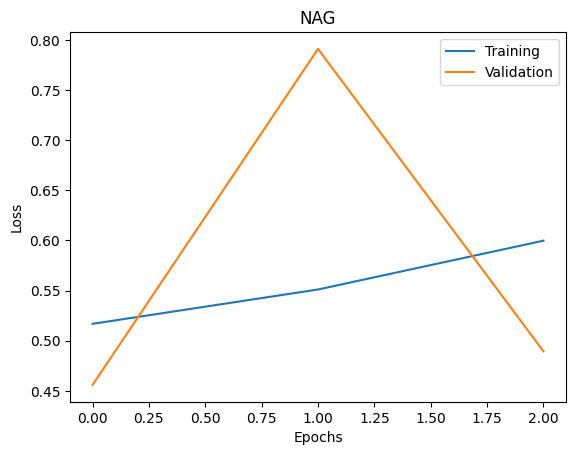

In [8]:
plt.figure()
plt.title("NAG")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()

### Test

In [9]:
model_3.evaluate(test_data, test_labels)

119/119 [==============================] - 0s 611us/step - loss: 0.5077 - accuracy: 0.8026


[0.5077103972434998, 0.8026350736618042]

In [10]:
pred_labels = model_3.predict(test_data, verbose=0)
pred_labels = np.argmax(pred_labels, axis=1)

confusion_matrix = tf.math.confusion_matrix(test_labels, pred_labels, num_classes=10)
print('(NAG)Confusion matrix on test data:\n')
print(confusion_matrix.numpy())

(NAG)Confusion matrix on test data:

[[626   0  32   0   0   0  28  73   0   0]
 [  2 722  32   0   0   0   2   1   0   0]
 [ 27  61 342   0   0   0 317  12   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [ 44   3  26   0   0   0 686   0   0   0]
 [ 11  39  18   0   0   0  21 670   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]
